In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import pprint
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from IPython import display
from matplotlib import pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', None)

In [2]:
# Downloaded from https://www.kaggle.com/datasets/kazanova/sentiment140

df = pd.read_csv(
    'data/training.1600000.processed.noemoticon.csv',
    names=["sentiment", "id", "date", "flag", "user", "text"],
    encoding="ISO-8859-1",
)

In [3]:
# Redefine classes from [0, 4] to [0, 1]
df['sentiment'].mask(df['sentiment'] == 4, 1, inplace=True)

# Drop unused columns
df = df[['sentiment', 'text']]

# Shuffle because dataset is sorted
df = shuffle(df)

df = df.head(10_000)
df.reset_index(drop=True, inplace=True)

In [4]:
vectorizer = CountVectorizer(
    input='content',
    lowercase=True,
    analyzer='word',
    ngram_range=(1, 2),
    strip_accents='ascii',
)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['sentiment'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
)

In [6]:
def show_acc_plot(accuracies_list):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 3))
        plt.plot(range(len(accuracies_list)), accuracies_list)
        plt.scatter(range(len(accuracies_list)), accuracies_list)
        display.display(plt.gcf())
        plt.close('all')

In [7]:
accuracies = []

Accuracy: 0.5196


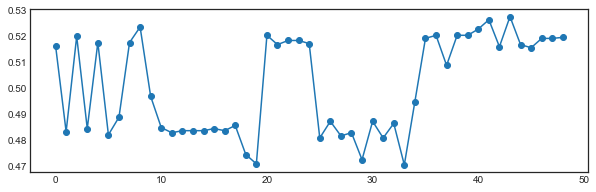

Yet unlabeled: (7451, 91473)


2610    At this bombass mexican food resty but I can't eat nathen from here 
Name: text, dtype: object

0


In [8]:
label_n = 50

for _ in range(label_n):
    display.clear_output(wait=True)
    if _ > 0:
        predicted = learner.predict(X_test)
        accuracy = accuracy_score(predicted, y_test)
        accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}")
        show_acc_plot(accuracies)
    print(f'Yet unlabeled: {X_train.shape}')
    
    query_idx, query_inst = learner.query(
        X_train,
        random_tie_break=True,
        n_instances=1,
    )

    display.display(df['text'][query_idx])

    # Manually assign class
    assigned_class = np.array([int(input())], dtype=int)

    # Teach with manually assigned class
    learner.teach(query_inst, assigned_class)

    # Remove labeled
    X_train = np.delete(X_train, query_idx, axis=0)
    y_train = np.delete(y_train, query_idx, axis=0)

In [10]:
learner.score(X_test, y_test)

0.5204